In [1]:
import numpy as np
import os
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import sqlite3
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import tensorflow as tf
from collections import Counter

In [2]:
%reload_ext autoreload
%autoreload 2

from functions_ml import refactor_video_into_input

ModuleNotFoundError: No module named 'functions_ml'

In [2]:
IMAGE_SIZE = (256, 256)
SEQUENCE_LENGTH = 15
POSE_START_INDEX = 11
POSE_END_INDEX = 23

IMG_DIR = 'test_img'
RECORDINGS_DIR = 'recordings'
LOADED_VIDEOS_DIR = 'loaded_videos'

DB_NAME = 'slr.db'
TABLE_NAME = 'sign_videos'

DETECTOR_MODEL_NAME = 'pose_landmarker.task'

In [4]:
os.getcwd()

'c:\\Users\\Piotr\\Python_projects\\Computer-Vision-Sign-Language\\jupyter_notebooks'

In [3]:
with open(DETECTOR_MODEL_NAME, 'rb') as det_bytes_model:
    model_data = det_bytes_model.read()

In [4]:
base_options = python.BaseOptions(model_asset_buffer=model_data)
running_mode = vision.RunningMode


detector_options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False,
    running_mode=running_mode.VIDEO)


### Connect to db

In [5]:
conn = sqlite3.connect(os.path.join("..", DB_NAME))
cursor = conn.cursor()

In [8]:
cursor.execute('SELECT name FROM sign_videos where verified = 1')
res = cursor.fetchall()

In [33]:
videos = os.listdir(os.path.join("..", LOADED_VIDEOS_DIR)) \
    + os.listdir(os.path.join("..", RECORDINGS_DIR))

In [34]:
to_del = set(res).difference(set(videos))
to_del

{'2023_11_12_13_49_31__SLR.webm'}

In [170]:
cursor.execute(f"DELETE FROM sign_videos WHERE name = '2023_11_14_10_40_49__SLR.webm'")
conn.commit()

### Get saved videos

In [6]:
cursor.execute('SELECT name, video_array, true_label FROM sign_videos where verified = 1')
res = cursor.fetchall()

In [7]:
v_names = [r[2] for r in res]
mapping_classes = {
    "hello": 0,
    "love": 1,
    "please": 2,
    "thank you": 3,
    "what": 4,
}


In [8]:
from collections import Counter
Counter(v_names)

Counter({'what': 97, 'thank you': 97, 'please': 96, 'hello': 96, 'love': 96})

In [23]:
X, Y = [], []
all_keypoints = []

In [33]:
for video_name, _, gesture in res:

    video_path = os.path.join("..", RECORDINGS_DIR, video_name)

    if not os.path.exists(video_path):
        video_path = os.path.join("..", LOADED_VIDEOS_DIR, video_name)

    if not os.path.exists(video_path):
        print(f"Path: {video_path} does not exist")

    print(f"Processing: {video_path}")

    try:

        keypoints = refactor_video_into_input(
            video_path=video_path,
            use_visibility=False,
            pose_indexes=(POSE_START_INDEX, POSE_END_INDEX),
            video_task=True,
            detector_options=detector_options,
            sequence_length=15,
        )

    except Exception as e:

        print(f"For {video_name} error occured: {e}")

    else:

        if not isinstance(keypoints, np.ndarray):
            continue

        # reshaped = keypoints.reshape(SEQUENCE_LENGTH, -1)

        
        update_sql = """
            UPDATE sign_videos SET video_array = ? WHERE name = ? 
        """

        try:
            cursor.execute(update_sql, (keypoints.tobytes(), video_name))
        except Exception as e:
            print(f"For {video_name} error occured: {e}")
        else:
            conn.commit()

        all_keypoints.append(keypoints)
        Y.append(gesture)

    finally:
        print('\n')

Processing: ..\recordings\please_video_1.mp4
Steps: 14 - applying padding


Processing: ..\recordings\please_video_4.mp4
Steps: 14 - applying padding


Processing: ..\recordings\please_video_5.mp4


Processing: ..\recordings\please_video_6.mp4


Processing: ..\recordings\please_video_7.mp4


Processing: ..\recordings\please_video_8.mp4
Steps: 14 - applying padding


Processing: ..\recordings\please_video_9.mp4


Processing: ..\recordings\please_video_10.mp4


Processing: ..\recordings\please_video_11.mp4
Steps: 14 - applying padding


Processing: ..\recordings\please_video_12.mp4


Processing: ..\recordings\please_video_13.mp4
Steps: 14 - applying padding


Processing: ..\recordings\please_video_14.mp4


Processing: ..\recordings\please_video_16.mp4


Processing: ..\recordings\please_video_17.mp4


Processing: ..\recordings\please_video_18.mp4
Steps: 14 - applying padding


Processing: ..\recordings\please_video_19.mp4


Processing: ..\recordings\please_video_20.mp4


Processing: ..\re

### Get keypoints for rotated image

In [9]:
translation_vec = np.array([-0.5, 0, -0.5])
# translation_vec2 = np.array([-0.5, 0, 0.5])

In [10]:
X = np.array([np.frombuffer(v, dtype=np.float16).reshape(SEQUENCE_LENGTH, -1, 3) for name, v, true_label in res])
Y = [label for _, _, label in res]

In [11]:
mapping_classes = {
    "hello": 0,
    "love": 1,
    "please": 2,
    "thank you": 3,
    "what": 4,
}

Y = [mapping_classes.get(y) for y in Y]

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X, 
    Y,
    train_size=0.9, 
    random_state=42, 
    stratify=Y
)

### Augmentation horizontal flip

In [13]:
X_aug_copy = X_train.copy()
X_aug_copy[:, :, :, 0] = 1 - X_aug_copy[:, :, :, 0]
X_aug_copy[:, :, :, 2] = 1 - X_aug_copy[:, :, :, 2]
X_train = np.concatenate((X_train, X_aug_copy), axis=0)

In [14]:
Y_train = np.concatenate((Y_train, Y_train), axis=0)

In [15]:
del X_aug_copy

In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
train_angles_x = np.arange(-15, 15, 2.5)
train_angels_y = np.arange(-35, 36, 1)
train_angles_z = np.arange(-3, 4, 2)

In [19]:
train_angles_x, train_angels_y, train_angles_z

(array([-15. , -12.5, -10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,
          7.5,  10. ,  12.5]),
 array([-35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23,
        -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,
         -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
          4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  33,  34,  35]),
 array([-3, -1,  1,  3]))

In [16]:
def get_rot_y(angle: int):

    theta = np.radians(angle)

    return np.array([
        [np.cos(theta), 0, -np.sin(theta)],
        [0, 1, 0],
        [np.sin(theta), 0, np.cos(theta)]
    ])

In [17]:
def get_rot_x(angle: int):

    theta = np.radians(angle)

    return np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])


In [18]:
def get_rot_z(angle: int):

    theta = np.radians(angle)

    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])


In [19]:
from typing import Callable

In [20]:
np.random.seed(42)

In [21]:
def rot_aug(
    X: np.array,
    Y: np.array or list,
    rot_mat_f: Callable,
    angles: np.array,
    set_part: float = 0.5,
    translation_vec: np.array = np.array([-0.5, 0, -0.5])) -> np.array:

    Y = np.array(Y)

    X_aug = None
    Y_aug = None

    for angle in angles:

        if angle == 0:
            continue

        rotation_matrix = rot_mat_f(angle)
        random_rotate_indexes = np.random.choice(X.shape[0], int(X.shape[0] * set_part), replace=False)
        
        rotation_result = (
            (rotation_matrix @ (X[random_rotate_indexes].reshape(-1, 3) + translation_vec).T).T 
            - translation_vec
        ).reshape(len(random_rotate_indexes), SEQUENCE_LENGTH, -1, 3)

        if X_aug is None:

            X_aug = rotation_result
            Y_aug = Y[random_rotate_indexes]
            continue

        X_aug = np.concatenate((X_aug, rotation_result))
        Y_aug = np.concatenate((Y_aug, Y[random_rotate_indexes]))

    return np.concatenate((X, X_aug)), np.concatenate((Y, Y_aug))

In [24]:
X_aug, Y_aug = rot_aug(
    X=X_train, 
    Y=Y_train,
    rot_mat_f=get_rot_y, 
    angles=train_angels_y,
    set_part=0.5,
    translation_vec=translation_vec
)

In [25]:
X_aug.shape, Y_aug.shape

((31176, 15, 12, 3), (31176,))

In [26]:
X_aug, Y_aug = rot_aug(
    X=X_aug, 
    Y=Y_aug,
    rot_mat_f=get_rot_x, 
    angles=train_angles_x,
    set_part=0.3
)

In [27]:
X_aug.shape, Y_aug.shape

((134048, 15, 12, 3), (134048,))

In [28]:
X_aug, Y_aug = rot_aug(
    X=X_aug, 
    Y=Y_aug,
    rot_mat_f=get_rot_z, 
    angles=train_angles_z,
    set_part=0.2
)

In [29]:
X_aug.shape, Y_aug.shape

((241284, 15, 12, 3), (241284,))

In [30]:
swap_pattern = [i + 1 if i % 2 == 0 else i - 1 for i in range(12)]
swap_pattern

[1, 0, 3, 2, 5, 4, 7, 6, 9, 8, 11, 10]

In [31]:
indexes_swap_hands = np.random.choice(
    np.arange(X_aug.shape[0]), 
    int(0.07 * X_aug.shape[0]), 
    replace=False
)

In [32]:
X_aug[indexes_swap_hands] = X_aug[indexes_swap_hands][:, :, swap_pattern]

In [33]:
X_aug.shape

(241284, 15, 12, 3)

In [34]:
indexes_gauss = np.random.choice(
    np.arange(X_aug.shape[0]), 
    int(0.3 * X_aug.shape[0]), 
    replace=False
)

In [35]:
gauss_noise = np.random.normal(0, 0.1, size=len(indexes_gauss))

In [36]:
gauss_noise = gauss_noise[:, np.newaxis, np.newaxis, np.newaxis]

In [37]:
X_aug[indexes_gauss, :, :, :] += gauss_noise

In [38]:
X_aug = X_aug.reshape(X_aug.shape[0], SEQUENCE_LENGTH, -1)
Y_aug = to_categorical(Y_aug)

In [39]:
X_aug = tf.cast(X_aug, tf.float32)
Y_aug = tf.cast(Y_aug, tf.float32)

### Simple training

In [40]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization

In [41]:
def create_lstm_model(input_shape, units):

    model = tf.keras.Sequential([

            Bidirectional(
                LSTM(
                    64,
                    return_sequences=False, 
                    activation='tanh', 
                    input_shape=input_shape, 
                    recurrent_dropout=0
                )
            ),
            Dropout(0.25),
            Dense(units=units, activation="softmax")
        ])

    return model
    

### **Set hyperparams and needed callbacks**

In [ ]:
import tensorflow_addons as tfa

In [43]:
LR = 0.0015
EPOCHS = 50
ES_PATIENCE = 4
LR_REDUCE = 1
BATCH_SIZE = 1024
VAL_BATCH_SIZE = 1024

In [44]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch > 0:
        return lr * 1.5
    else:
        return lr

# Create the LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_scheduler)

In [45]:
lstm_model = create_lstm_model(input_shape=(SEQUENCE_LENGTH, X_aug.shape[-1]), units=len(set(Y)))

lstm_model.compile(optimizer=tfa.optimizers.AdamW(weight_decay=0.002, learning_rate=LR, clipnorm=1.0), #choosing optimizer
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #loss function
                    metrics=['categorical_accuracy']) 

# path_to_convlstm_model = os.path.join('models', 'lstm_more_data.ckpt')
path_to_convlstm_history = os.path.join('models', 'ROT_AUG_TRAIN_15seq.csv')

callbacks = [EarlyStopping(monitor='val_loss', patience=ES_PATIENCE, restore_best_weights=True),
             CSVLogger(path_to_convlstm_history, append=True),
             lr_callback]

### **Train model**

In [46]:
lstm_history = lstm_model.fit(  
    x=X_aug,
    y=Y_aug,
    # validation_data=(X_val_kp_diff, Y_val),
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_batch_size=VAL_BATCH_SIZE,
    workers=-1,
    use_multiprocessing=True,
    callbacks = callbacks
)

Epoch 1/50
189/189 [==============================] - 7s 15ms/step - loss: 0.5428 - categorical_accuracy: 0.8049 - val_loss: 0.1753 - val_categorical_accuracy: 0.9495 - lr: 0.0015
Epoch 2/50
189/189 [==============================] - 2s 11ms/step - loss: 0.1666 - categorical_accuracy: 0.9478 - val_loss: 0.1141 - val_categorical_accuracy: 0.9664 - lr: 0.0022
Epoch 3/50
189/189 [==============================] - 2s 11ms/step - loss: 0.1575 - categorical_accuracy: 0.9480 - val_loss: 0.0936 - val_categorical_accuracy: 0.9676 - lr: 0.0034
Epoch 4/50
189/189 [==============================] - 2s 11ms/step - loss: 0.1245 - categorical_accuracy: 0.9593 - val_loss: 0.0741 - val_categorical_accuracy: 0.9766 - lr: 0.0051
Epoch 5/50
189/189 [==============================] - 2s 11ms/step - loss: 0.1098 - categorical_accuracy: 0.9639 - val_loss: 0.0730 - val_categorical_accuracy: 0.9770 - lr: 0.0076
Epoch 6/50
189/189 [==============================] - 2s 11ms/step - loss: 0.0841 - categorical_accu

In [47]:
n = len(lstm_history.history.get('loss'))

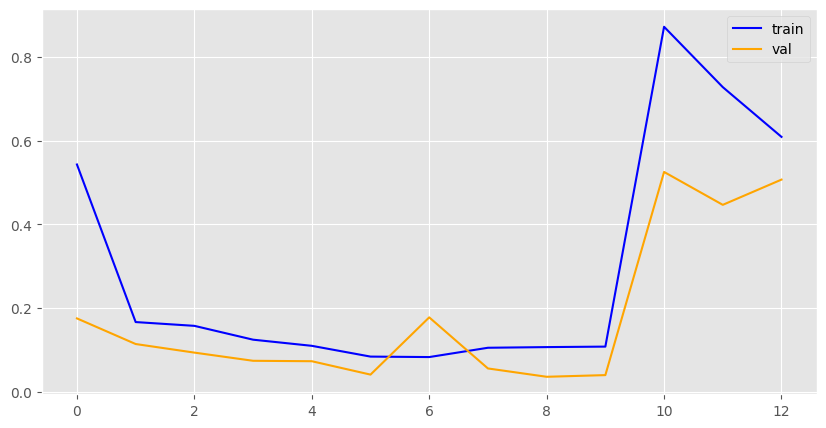

In [48]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(n), lstm_history.history.get('loss'), color='blue', label='train')
ax.plot(np.arange(n), lstm_history.history.get('val_loss'), color='orange', label='val')

plt.legend()
plt.show()


In [53]:
X_train_preds = lstm_model.predict(X_aug)

In [56]:
np.sum(np.argmax(X_train_preds, axis=1) == np.argmax(Y_aug, axis=1)) / len(Y_aug)

0.9899951923873941

In [58]:
X_test_preds = lstm_model.predict(X_val.reshape(X_val.shape[0], SEQUENCE_LENGTH, -1))
np.sum(np.argmax(X_test_preds, axis=1) == Y_val) / len(Y_val)

0.9795918367346939

In [59]:
lstm_model.save(os.path.join("..", "models", "LSTM_ROTATION_AUG_98.ckpt"))

INFO:tensorflow:Assets written to: ..\models\LSTM_ROTATION_AUG_98.ckpt\assets


INFO:tensorflow:Assets written to: ..\models\LSTM_ROTATION_AUG_98.ckpt\assets


In [256]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

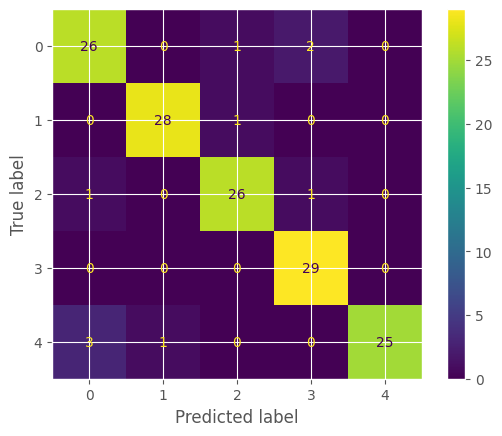

In [263]:
cm = confusion_matrix(
    y_true=np.argmax(Y_val, axis=1), 
    y_pred=np.argmax(val_preds, axis=1))


disp = ConfusionMatrixDisplay(
    confusion_matrix=cm)

disp.plot()
plt.show()

TypeError: imshow() missing 1 required positional argument: 'X'

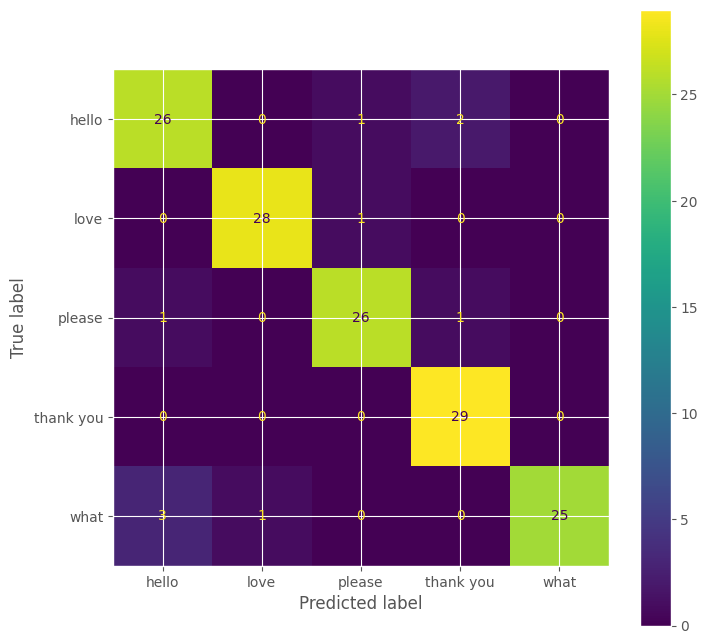

In [254]:
fig, ax = plt.subplots(figsize=(8, 8))

ConfusionMatrixDisplay.from_predictions(
    y_true=np.argmax(Y_val, axis=1),
    y_pred=np.argmax(val_preds, axis=1),
    display_labels=mapping_classes.keys(),
    ax=ax)


plt.imshow()


In [248]:
lstm_model.save(os.path.join("..", "models", "LSTM_ROTATION_AUG_93.ckpt"))

INFO:tensorflow:Assets written to: ..\models\LSTM_ROTATION_AUG_93.ckpt\assets


INFO:tensorflow:Assets written to: ..\models\LSTM_ROTATION_AUG_93.ckpt\assets


In [366]:
X_val_train, X_val_test, Y_val_train, Y_val_test = train_test_split(
    X_val, 
    Y_val,
    train_size=0.667, 
    random_state=42, 
    stratify=Y_val
)

In [367]:
X_val_train, Y_val_train = rot_aug(
    X=X_val_train, 
    Y=Y_val_train,
    rot_mat_f=get_rot_y, 
    angles=train_angels_y,
    set_part=0.5,
    translation_vec=translation_vec
)

In [368]:
X_val_train.shape, Y_val_train.shape

((3456, 15, 12, 3), (3456,))

In [369]:
X_val_train, Y_val_train = rot_aug(
    X=X_val_train, 
    Y=Y_val_train,
    rot_mat_f=get_rot_x, 
    angles=train_angles_x,
    set_part=0.3
)

In [370]:
X_val_train, Y_val_train = rot_aug(
    X=X_val_train, 
    Y=Y_val_train,
    rot_mat_f=get_rot_z, 
    angles=train_angles_z,
    set_part=0.2
)

In [371]:
X_val_train.shape, Y_val_train.shape

((26732, 15, 12, 3), (26732,))

In [372]:
swap_pattern = [i + 1 if i % 2 == 0 else i - 1 for i in range(12)]
swap_pattern

[1, 0, 3, 2, 5, 4, 7, 6, 9, 8, 11, 10]

In [373]:
indexes_swap_hands = np.random.choice(
    np.arange(X_val_train.shape[0]), 
    int(0.07 * X_val_train.shape[0]), 
    replace=False
)

In [374]:
X_val_train[indexes_swap_hands] = X_val_train[indexes_swap_hands][:, :, swap_pattern]

In [375]:
indexes_gauss = np.random.choice(
    np.arange(X_val_train.shape[0]), 
    int(0.3 * X_val_train.shape[0]), 
    replace=False
)

In [376]:
gauss_noise = np.random.normal(0, 0.1, size=len(indexes_gauss))

In [377]:
gauss_noise = gauss_noise[:, np.newaxis, np.newaxis, np.newaxis]

In [378]:
X_val_train[indexes_gauss, :, :, :] += gauss_noise

In [403]:
model = tf.keras.models.load_model(
    os.path.join("..", "models", "LSTM_ROTATION_AUG_93.ckpt")
)

In [404]:
model.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=0.002, learning_rate=1e-14, clipnorm=1.0), #choosing optimizer
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #loss function
    metrics=['categorical_accuracy']
) 

In [405]:
callbacks = [EarlyStopping(monitor='val_loss', patience=ES_PATIENCE, restore_best_weights=True),
             CSVLogger(path_to_convlstm_history, append=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_REDUCE)]

In [381]:
X_val_train = X_val_train.reshape(X_val_train.shape[0], SEQUENCE_LENGTH, -1)
X_val_train = tf.cast(X_val_train, tf.float32)

In [382]:
Y_val_train = to_categorical(Y_val_train)

In [355]:
# tf.data.experimental.enable_debug_mode()

In [392]:
model.layers[0].trainable = False

In [406]:
lstm_history_finetuning = model.fit(  
    x=X_val_train,
    y=Y_val_train,
    # validation_data=(X_val_kp_diff, Y_val),
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_batch_size=VAL_BATCH_SIZE,
    workers=-1,
    use_multiprocessing=True,
    callbacks = callbacks
)

Epoch 1/50
42/42 [==============================] - 3s 74ms/step - loss: 0.4461 - categorical_accuracy: 0.8904 - val_loss: 0.4808 - val_categorical_accuracy: 0.8700 - lr: 1.0000e-14
Epoch 2/50
42/42 [==============================] - 3s 77ms/step - loss: 0.6213 - categorical_accuracy: 0.8177 - val_loss: 0.7442 - val_categorical_accuracy: 0.7558 - lr: 1.0000e-14
Epoch 3/50
42/42 [==============================] - 3s 75ms/step - loss: 0.9233 - categorical_accuracy: 0.6587 - val_loss: 1.0592 - val_categorical_accuracy: 0.5788 - lr: 1.0000e-14
Epoch 4/50
12/42 [=======>......................] - ETA: 2s - loss: 1.1170 - categorical_accuracy: 0.5508

KeyboardInterrupt: 

In [394]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_17 (Bidirecti  (None, 128)              51712     
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 5)                 645       
                                                                 
Total params: 52,357
Trainable params: 645
Non-trainable params: 51,712
_________________________________________________________________


In [396]:
train_val_preds = model.predict(X_val_train)

In [397]:
np.sum(np.argmax(train_val_preds, axis=1) == np.argmax(Y_val_train, axis=1)) / len(Y_val_train)

0.9754227143498428

In [399]:
X_aug.shape

TensorShape([186122, 15, 36])

In [ ]:
train_preds = model.predict(X_aug)

In [ ]:
np.sum(np.argmax(train_preds, axis=1) == np.argmax(Y_aug, axis=1)) / len(Y_aug)

In [400]:
val_preds = model.predict(X_val_test.reshape(X_val_test.shape[0], SEQUENCE_LENGTH, -1))

In [402]:
np.sum(np.argmax(val_preds, axis=1) == Y_val_test) / len(Y_val_test)

0.8958333333333334

In [ ]:
org_preds = model.predict(X.reshape(X.shape[0], SEQUENCE_LENGTH, -1))

In [ ]:
np.sum(np.argmax(val_preds, axis=1) == np.argmax(Y_val, axis=1)) / len(Y_val)

0.8819444444444444

In [ ]:
np.sum(np.argmax(org_preds, axis=1) == Y) / len(Y)

0.9330543933054394